### PENGARUH BATCH SIZE PADA TRAINING AKURASI ALGORITMA CNN (STUDI KASUS SISTEM PAKAR TANAMAN KENTANG)

#### Tahap 1 : Memuat Dataset

In [1]:
%pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [2]:
%pip install opencv-python

Note: you may need to restart the kernel to use updated packages.


In [3]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

2023-09-14 12:42:34.580937: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-14 12:42:34.611302: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-14 12:42:34.611670: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-14 12:42:35.510481: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [4]:
IMAGE_SIZE = 150 #Mengubah ukuran gambar sebelum diproses oleh model
BATCH_SIZE = 32 #Menentukan berapa banyak gambar yang akan diproses dalam satu iterasi selama pelatihan model
CHANNELS = 3 #Menetukan jumlah saluran warna dalam gambar

In [5]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "Dataset/PENYAKIT KENTANG", #Untuk memuat dataset yang sudah dikumpulkan
    shuffle = True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 5160 files belonging to 10 classes.


In [6]:
#Mencek jumlah class yang tersedia
classes  = dataset.class_names
classes

['Bacterial--Ring-Rot',
 'Bacterial--Soft--Rot',
 'Batang--Healthy',
 'Common--Scab',
 'Daun--Healthy',
 'Early--Blight',
 'Fusarium--wilt',
 'Late--Blight',
 'Stem--Rust',
 'Umbi--Healthy']

In [7]:
for image_batch, label_batch in dataset.take(1):
  print(image_batch.shape)

(32, 150, 150, 3)


Untuk menampilkan beberapa gambar dari jumlah dataset yang ada, bertujuan untuk memvisualisasikan citra dataset sesuai dengan masing-masing kelas yang telah ditentukan

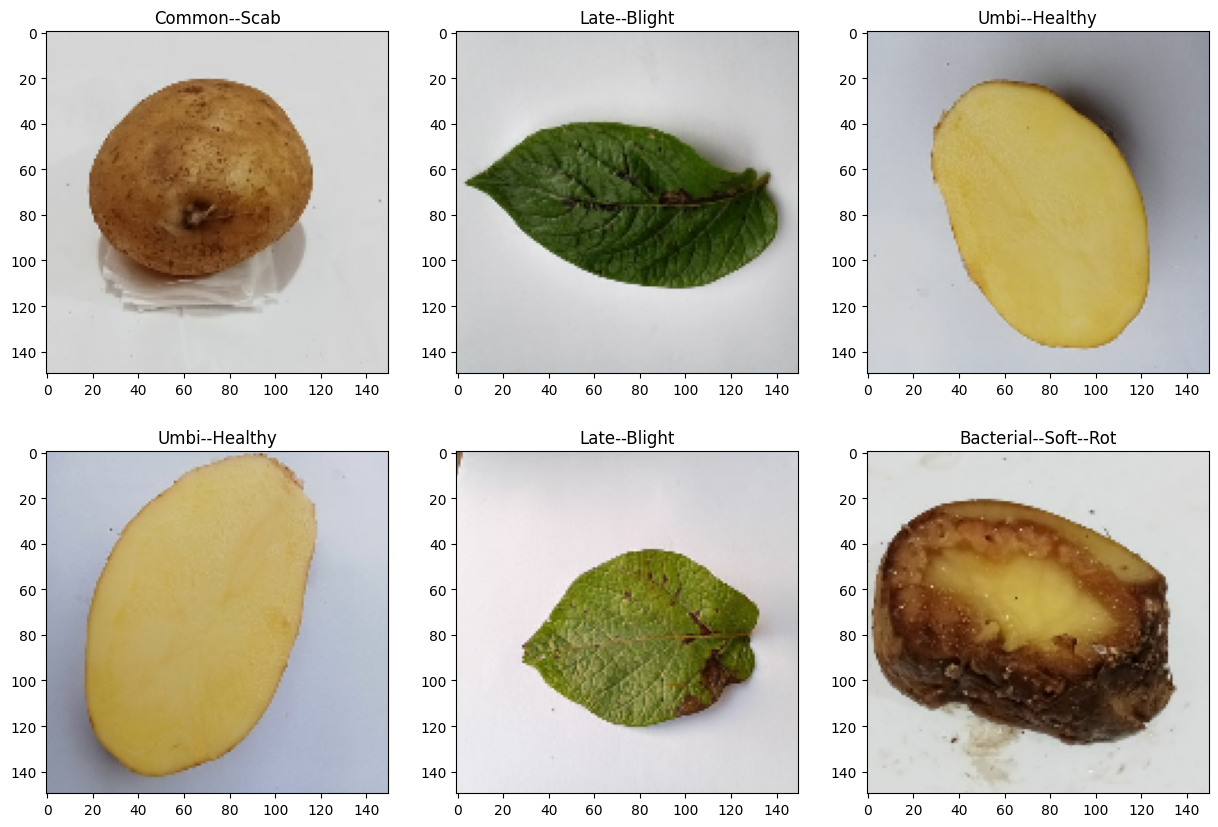

In [8]:

plt.figure(figsize=(15, 10))

for image_batch, label_batch in dataset.take(1):
  for i in range(6):
    ax = plt.subplot(2, 3, i + 1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    plt.title(classes[label_batch[i]])

#### Tahap 2 : Splitting Data

Pada penelitian ini akan memecah data menjadi 80:10:10 karena setelah mencoba skenario pembagian data 80:10:10 dan 70:15:15, pembagian data 80% memiliki akurasi yang lebih baik. Pembagian dataset ini penting untuk  menghasilkan model yang dapat diuji dan dievaluasi dengan benar.

In [9]:
def get_dataset_partition_tf(dataset, train_split = 0.8, validation_split = 0.1, test_split = 0.1, shuffle = True, shuffle_size = 10000):
  dataset_size = len(dataset)

  if shuffle:
    dataset = dataset.shuffle(shuffle_size, seed = 18)

  train_size = int(train_split * dataset_size)
  validation_size = int(validation_split * dataset_size)

  train_dataset = dataset.take(train_size)
  validation_dataset = dataset.skip(train_size).take(validation_size)
  test_dataset = dataset.skip(train_size).skip(validation_size)

  return train_dataset, validation_dataset, test_dataset

In [10]:
train_dataset, validation_dataset, test_dataset = get_dataset_partition_tf(dataset)

In [11]:
#Cek jumlah batch data train
len(train_dataset)

129

In [12]:
#Cek jumlah batch data validation
len(validation_dataset)

16

In [13]:
#Cek jumlah batch data test
len(test_dataset)

17

In [14]:
train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
validation_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

**Resize dan Resacle**

In [15]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1./255)
])

In [16]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

#### Tahap 3 : Membuat Model Convolutional Neural Network (CNN)

In [17]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS) #Menentukan bentuk input yang akan digunakan model
n_classes = 10 #Jumlah Class

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = input_shape), #mengenali gambar berdasarkan piksel-piksel yang ada pada gambar
    layers.MaxPooling2D((2, 2)), #mereduksi dimensi gambar
    layers.Conv2D(64, kernel_size = (3, 3), activation = 'relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size = (3, 3), activation = 'relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(), #mengubah output dari lapisan menjadi vektor 
    layers.Dense(64, activation = 'relu'),
    layers.Dense(n_classes, activation = 'softmax') #fungsi aktivasi yang diterapkan pada setiap neuron dalam lapisan dense untuk klasifikasi
])
model.build(input_shape = input_shape)

In [18]:
#menampilkan ringkasan dari arsitektur model
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 150, 150, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 150, 150, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 148, 148, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 74, 74, 32)          0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 72, 72, 64)          18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 36, 36, 64)          0         
 g2D)                                                 

#### Tahap 4 : Pelatihan model dengan metode Convolutional Neural Network (CNN)

In [19]:
model.compile(
    optimizer = 'adam', #untuk mengoptimalkan parameter-model selama proses pelatihan
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False), #untuk mengukur seberapa baik dengan data pelatihan dan seberapa jauh prediksi model
    metrics = ['accuracy'] #untuk persentase data yang diprediksi dengan benar oleh model dari total data
)

In [20]:
history = model.fit(
    train_dataset, #dataset pelatihan yang akan digunakan untuk melatih model
    epochs = 10, #jumlah siklus melalui seluruh dataset pelatihan yang akan digunakan selama pelatihan
    batch_size = BATCH_SIZE,
    verbose = 1,
    validation_data = validation_dataset,
)

Epoch 1/10


2023-09-14 12:42:53.311207: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 55 of 10000
2023-09-14 12:43:00.452132: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.
2023-09-14 12:43:00.452192: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 1 of 1000
2023-09-14 12:43:00.452430: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.
2023-09-14 12:43:00.488389: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 89718784 exceeds 10% of free system memory.
2023-09-14 12:43:00.797195: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 22429696 exceeds 10% of free system memory.
2023-09-14 12:43:00.807211: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 42467328 exceeds 10% of free system memory.
2023-09-14 12:43:00.970808: W tensorflow/tsl/framework/cpu_allocator_

129/129 [==============================] - 77s 449ms/step - loss: 1.1181 - accuracy: 0.5748 - val_loss: 0.7516 - val_accuracy: 0.7105
Epoch 2/10
129/129 [==============================] - 56s 438ms/step - loss: 0.2774 - accuracy: 0.9020 - val_loss: 0.2605 - val_accuracy: 0.9120
Epoch 3/10
129/129 [==============================] - 55s 430ms/step - loss: 0.1460 - accuracy: 0.9535 - val_loss: 0.1568 - val_accuracy: 0.9396
Epoch 4/10
129/129 [==============================] - 55s 431ms/step - loss: 0.2091 - accuracy: 0.9349 - val_loss: 0.1591 - val_accuracy: 0.9500
Epoch 5/10
129/129 [==============================] - 54s 423ms/step - loss: 0.1361 - accuracy: 0.9527 - val_loss: 0.1057 - val_accuracy: 0.9642
Epoch 6/10
129/129 [==============================] - 55s 428ms/step - loss: 0.0866 - accuracy: 0.9766 - val_loss: 0.3260 - val_accuracy: 0.8989
Epoch 7/10
129/129 [==============================] - 55s 424ms/step - loss: 0.1159 - accuracy: 0.9630 - val_loss: 0.0732 - val_accuracy: 0.9

In [21]:
scores = model.evaluate(test_dataset)

129/129 [==============================] - 12s 90ms/step - loss: 0.0602 - accuracy: 0.9837


In [22]:
accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

loss = history.history['loss']
validation_loss = history.history['val_loss']

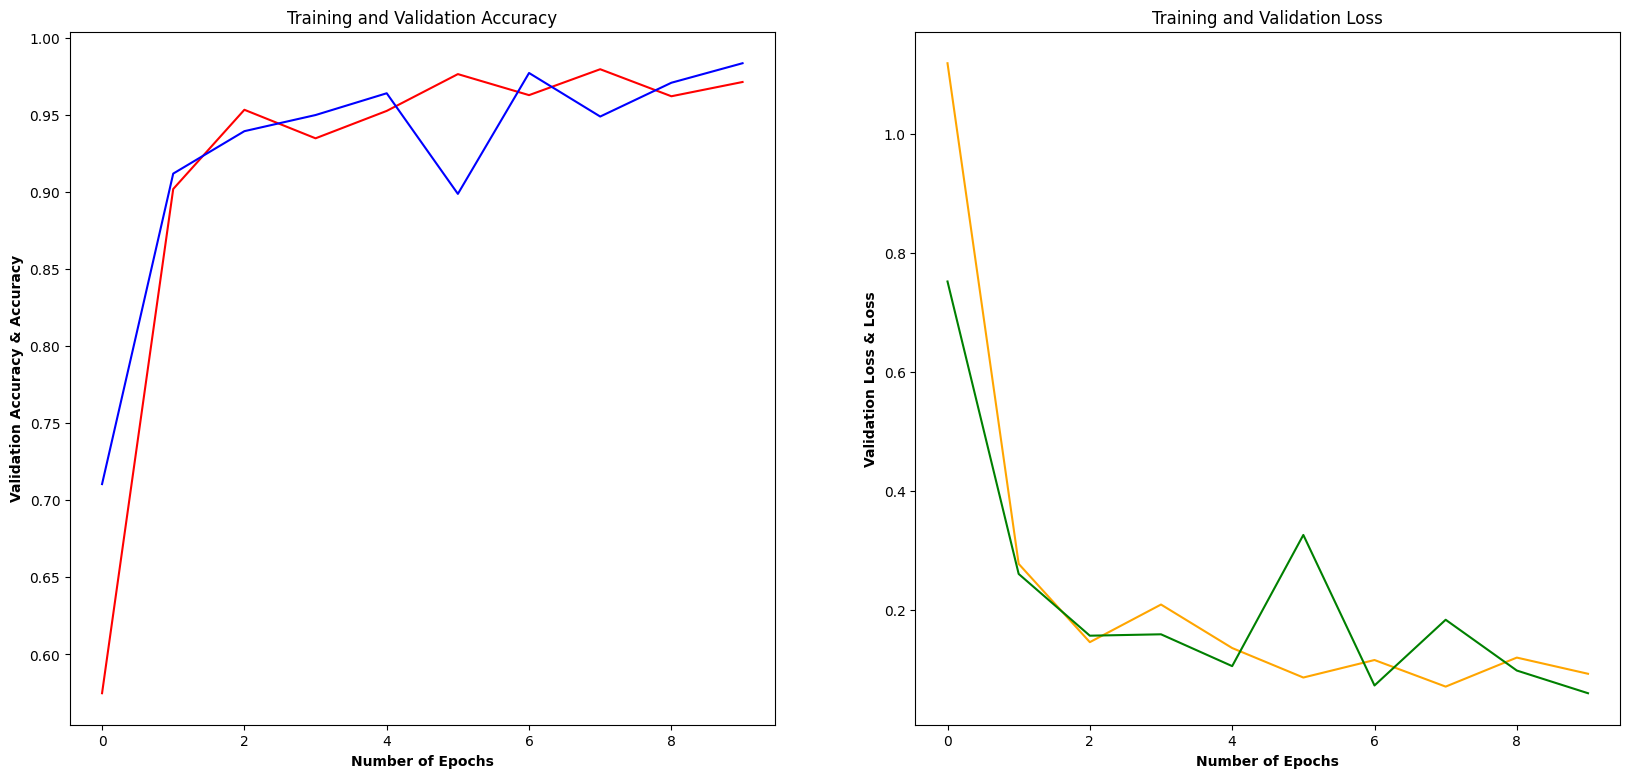

In [23]:
plt.figure(figsize = (20, 9), linewidth = 1.5)
plt.subplot(1, 2, 1)
plt.plot(range(10), accuracy, label = 'Training Accuracy', c = 'red')
plt.plot(range(10), validation_accuracy, label = 'Validation Accuracy', c = 'blue')
plt.title('Training and Validation Accuracy')
plt.xlabel('Number of Epochs', fontweight='bold')
plt.ylabel('Validation Accuracy & Accuracy', fontweight='bold')

plt.subplot(1, 2, 2)
plt.plot(range(10), loss, label = 'Training Loss', c = 'orange')
plt.plot(range(10), validation_loss, label = 'Validation Loss', c = 'green')
plt.title('Training and Validation Loss')
plt.xlabel('Number of Epochs', fontweight='bold')
plt.ylabel('Validation Loss & Loss', fontweight='bold')

plt.show()

### Tahap 5 : Pengujian Model Dengan Confusion Matrix

In [24]:
def predict(model,img):
    image = tf.keras.utils.img_to_array(img)
    image = tf.expand_dims(image,0)

    pred = model.predict(image)
    pred_class = classes[np.argmax(pred[0])]
    confidence = round(100 * (np.max(pred[0])),2)
    return pred_class,confidence

In [26]:
from sklearn.metrics import confusion_matrix

In [70]:
import numpy as np
y_test = []
y_pred = []

for image_batch,label_batch in test_dataset.take(1):
    y_test = label_batch[:]
    pred = model.predict(image_batch)
    y_pred = [np.argmax(i) for i in pred]

cm = confusion_matrix(y_test,y_pred)
cm

1/1 [==============================] - 0s 120ms/step


array([[6, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 2, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 5, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 6, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 6, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 3, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1]])

In [63]:
import seaborn as sns

<Axes: >

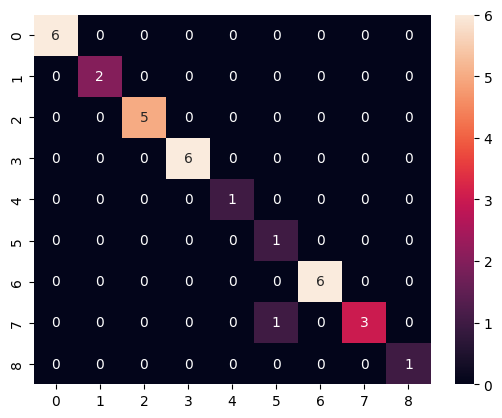

In [71]:
sns.heatmap(cm,annot=True)

In [72]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
print(f'confusion_matrix:\n {confusion_matrix(y_test, y_pred)}')
print (classification_report(y_test, y_pred, zero_division=0))

confusion_matrix:
 [[6 0 0 0 0 0 0 0 0]
 [0 2 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0]
 [0 0 0 6 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 6 0 0]
 [0 0 0 0 0 1 0 3 0]
 [0 0 0 0 0 0 0 0 1]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         2
           2       1.00      1.00      1.00         5
           3       1.00      1.00      1.00         6
           5       1.00      1.00      1.00         1
           6       0.50      1.00      0.67         1
           7       1.00      1.00      1.00         6
           8       1.00      0.75      0.86         4
           9       1.00      1.00      1.00         1

    accuracy                           0.97        32
   macro avg       0.94      0.97      0.95        32
weighted avg       0.98      0.97      0.97        32



actual label:  Fusarium--wilt
1/1 [==============================] - 0s 119ms/step
predicted label:  Fusarium--wilt


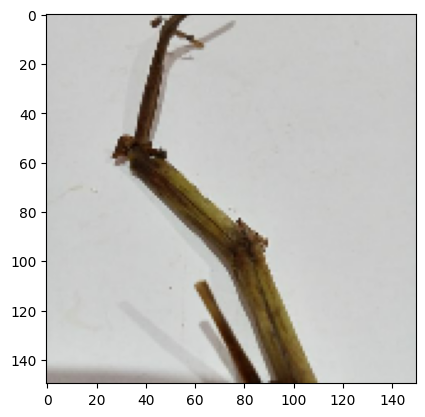

In [32]:
import numpy as np

for images_batch, labels_batch in test_dataset.take(1):
  first_image = images_batch[0].numpy().astype('uint8')
  first_label = labels_batch[0]

  plt.imshow(first_image)
  print("actual label: ", classes [first_label])

  batch_prediction = model.predict(images_batch)
  print("predicted label: ", classes [np.argmax(batch_prediction[0])])

In [33]:
def predict(model, img):
  img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
  img_array = tf.expand_dims(img_array, 0)  #creating a batch

  predictions = model.predict(img_array)

  predicted_class = classes[np.argmax(predictions[0])]
  confidence = round(100 * (np.max(predictions[0])), 2)
  return predicted_class, confidence

1/1 [==============================] - 0s 17ms/step


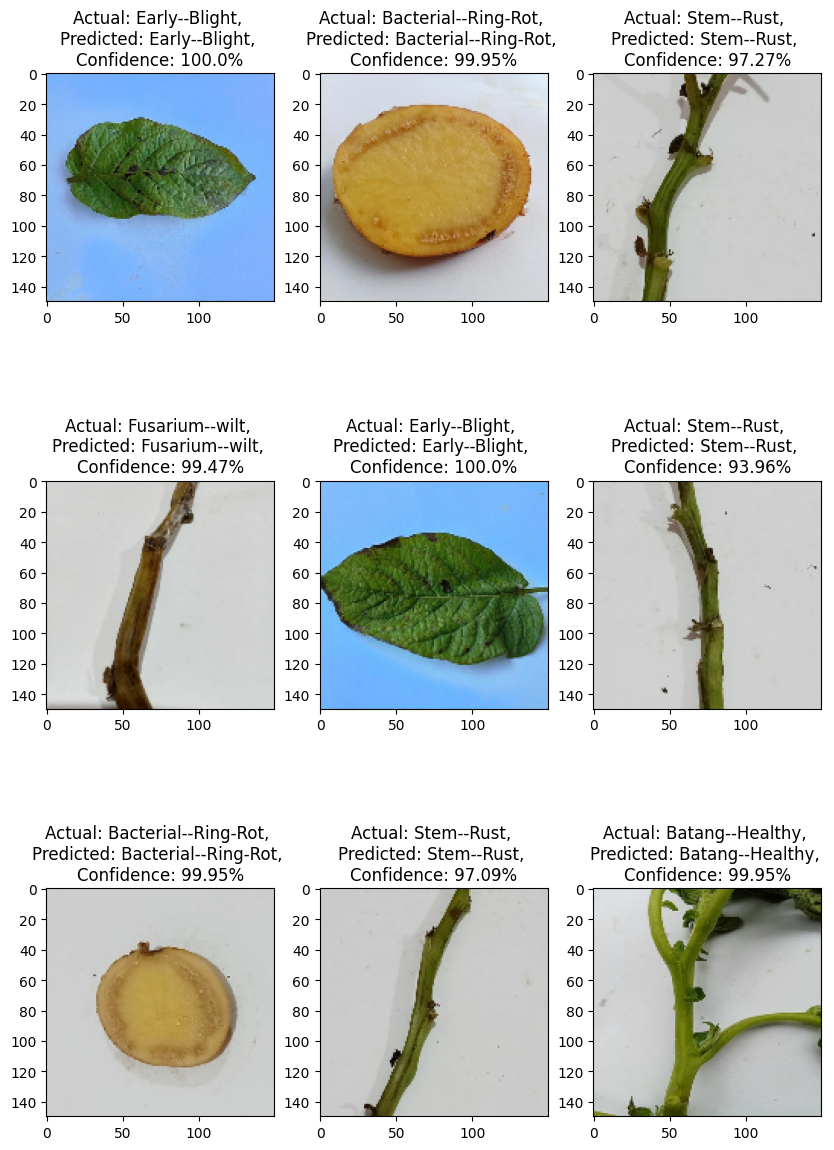

In [34]:
plt.figure(figsize = (10, 15))
for images, labels in test_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))

    predicted_class, confidence = predict(model, images[i].numpy())
    actual_class = classes[labels[i]]

    plt.title(f"Actual: {actual_class}, \nPredicted: {predicted_class}, \nConfidence: {confidence}%")